In [431]:
import pandas as pd
import sklearn
import numpy as np
import graphviz
import warnings
import sklearn.ensemble
import sklearn.tree
import sklearn.metrics
import sklearn.svm
import sklearn.linear_model
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import random
import scipy
import seaborn

from sklearn.model_selection import train_test_split

from ggplot import *

import matplotlib.pyplot as plt
%matplotlib inline

import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls


In [9]:
# def mse(model, testDf, yName, xNames):
#     results = []
#     for i, row in testDf.iterrows():
#         xVal = [row[n] for n in xNames]
#         yVal = row[yName]
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")
#             results.append((model.predict(xVal) - yVal) ** 2)
#     return np.mean(results)

In [409]:
def mse(clf, X, y):
    se = []
    pred = clf.predict(X)
    se.append((pred - y)**2)
    return np.mean(se)

def ter(clf, X, y):
    se = []
    pred = np.round(clf.predict(X))
    se.append(abs(pred - y))
    return np.mean(se)

def compare_k_mse (weighted, trainDF, testDF, y_col, k):
    MSEs = []
    x_col = np.delete(np.arange(trainDF.shape[1]), y_col)
    
    X = trainDF.iloc[:, x_col]
    y = trainDF.iloc[:, y_col]

    for i in k:
        if weighted:
            clf = KNeighborsClassifier(n_neighbors=i, weights ='distance')
        else: 
            clf = KNeighborsClassifier(n_neighbors=i)
        clf.fit(X,y)
        X_test = testDF.iloc[:, x_col]
        y_test = testDF.iloc[:, y_col]
        MSEs.append( mse(clf, X_test, y_test))
    d = {"Neighbor_num": k, "MSE": MSEs}
    mseDF = pd.DataFrame(d).sort_values(by = 'MSE', ascending = True)
    return mseDF

def compare_k_ter (weighted, trainDF, testDF, y_col, k):
    TERs = []
    x_col = np.delete(np.arange(trainDF.shape[1]), y_col)
    
    X = trainDF.iloc[:, x_col]
    y = trainDF.iloc[:, y_col]

    for i in k:
        if weighted:
            clf = KNeighborsClassifier(n_neighbors=i, weights ='distance')
        else: 
            clf = KNeighborsClassifier(n_neighbors=i)
        clf.fit(X,y)
        X_test = testDF.iloc[:, x_col]
        y_test = testDF.iloc[:, y_col]
        TERs.append(ter(clf, X_test, y_test))
        #TERs.append(1-sklearn.metrics.accuracy_score(y_true = y_test, y_pred = np.round(clf.predict(X_test))))
    d = {"Neighbor_num": k, "Test error rate": TERs}
    terDF = pd.DataFrame(d).sort_values(by = 'Test error rate', ascending = True)
    return terDF

def compare_models_mse (models, trainDF, testDF, y_col):
    MSEs = []
    x_col = np.delete(np.arange(trainDF.shape[1]), y_col)
    
    X = trainDF.iloc[:, x_col]
    y = trainDF.iloc[:, y_col]

    for clf in models:
        clf.fit(X,y)
        X_test = testDF.iloc[:, x_col]
        y_test = testDF.iloc[:, y_col]
        MSEs.append( mse(clf, X_test, y_test))
    d = {"Model": ["Linear Regression", "Decision tree", "Boosting", "Random Forest"], "MSE": MSEs}
    mseDF = pd.DataFrame(d).sort_values(by = 'MSE', ascending = True)
    return mseDF

def compare_models_ter (models, trainDF, testDF, y_col):
    TERs = []
    x_col = np.delete(np.arange(trainDF.shape[1]), y_col)
    
    X = trainDF.iloc[:, x_col]
    y = trainDF.iloc[:, y_col]

    for clf in models:
        clf.fit(X,y)
        X_test = testDF.iloc[:, x_col]
        y_test = testDF.iloc[:, y_col]
        TERs.append(ter(clf, X_test, y_test))
        #TERs.append(1-sklearn.metrics.accuracy_score(y_test, np.round(clf.predict(X_test))))
    d = {"Model": ["Linear Regression", "Decision tree", "Boosting", "Random Forest", "SVM"], "TER": TERs}
    terDF = pd.DataFrame(d).sort_values(by = 'TER', ascending = True)
    return terDF

# Question 1

## Part 1

In [245]:
f_data = pd.read_csv('feminist.csv')
f_train, f_test = train_test_split(f_data, test_size=0.3, random_state=123)
f_train[:3]

,feminist,female,age,educ,income,dem,rep
1518,50,1,54,15,17,0,0
828,0,0,46,13,14,0,1
1208,60,1,45,12,1,1,0


## Part 2
Calculate the test MSE for KNN models with $K = 5, 10, 15, \dots, 100$, using whatever combination of variables you see fit. Which model produces the lowest test MSE?

For this part, we use all independent variables

In [217]:
k = np.arange(5, 101)
compare_k_mse(False, f_train, f_test, 0, k)[:10]

,MSE,Neighbor_num
60,520.494526,65
57,523.459854,62
59,523.733577,64
61,524.509124,66
87,524.645985,92
62,526.105839,67
86,526.288321,91
84,526.288321,89
85,526.516423,90
82,526.607664,87


Thus, we get the lowest MSE using 65 neighbors.

## Part 3
Calculate the test MSE for weighted KNN models with $K = 5, 10, 15, \dots, 100$ using the same combination of variables as before. Which model produces the lowest test MSE?

In [378]:
q1_3 = compare_k_mse(True, f_train, f_test, 0, k)[:5]
q1_3

,MSE,Neighbor_num
9,644.354015,10
8,658.268248,9
7,682.127737,8
6,705.895985,7
5,722.866788,6


Cluster using 97 neighbors perform the best

## Part 4
<span style="color:red"> Compare the test MSE for the best KNN/wKNN model(s) to the test MSE for the equivalent linear regression, decision tree, boosting, and random forest methods using the same combination of variables as before. Which performs the best? Why do you think this method performed the best, given your knowledge of how it works?

In [225]:
models = [sklearn.linear_model.LinearRegression(), sklearn.tree.DecisionTreeClassifier(),
         sklearn.ensemble.AdaBoostClassifier(), sklearn.ensemble.RandomForestClassifier()]
compare_models_mse(models, f_train, f_test, 0)

,MSE,Model
0,448.831477,Linear Regression
2,554.390511,Boosting
3,762.600365,Random Forest
1,877.109489,Decision tree


According to MESs of these four models and (weighted) KNNs, linear regression performs the best. This suggest that there is an underlying linear relationship between independent variables and their attitudes towards feminism.

# Question 2

## Part 1
Split the data into a training and test set (70/30).

In [246]:
mh_data = pd.read_csv('mental_health.csv').dropna()
#random.seed(1234)
mh_train, mh_test = train_test_split(mh_data, test_size=0.3, random_state=123)
mh_train[:3]

,vote96,mhealth_sum,age,educ,black,female,married,inc10
877,0.0,2.0,33.0,11.0,0.0,0.0,0.0,7.2223
11,1.0,1.0,41.0,15.0,1.0,1.0,1.0,8.8273
1674,1.0,5.0,40.0,12.0,0.0,0.0,1.0,3.4774


## Part 2
Calculate the test error rate for KNN models with $K = 1,2,\dots,10$, using whatever combination of variables you see fit. Which model produces the lowest test MSE?

For this part, we'll use all independent variables.

In [381]:
k = np.arange(1, 11)
compare_k_ter(False, mh_train, mh_test, 1, k)[:5]

,Neighbor_num,Test error rate
9,10,2.571429
7,8,2.588571
8,9,2.597143
1,2,2.642857
2,3,2.654286


We got the lowest MSE using 1 neighbor in this case.

## Part 3
Calculate the test error rate for weighted KNN models with $K = 1,2,\dots,10$ using the same combination of variables as before. Which model produces the lowest test error rate?

In [384]:
q2_3 = compare_k_ter(True, mh_train, mh_test, 1, k).iloc[:5,:]
q2_3

,Neighbor_num,Test error rate
7,8,2.580000
9,10,2.591429
8,9,2.594286
6,7,2.600000
5,6,2.660000


We got the lowest test error rate using 5 neighbors in this case.

## Part 4
<span style="color:red"> Compare the test error rate for the best KNN/wKNN model(s) to the test error rate for the equivalent logistic regression, decision tree, boosting, random forest, and SVM methods using the same combination of variables as before. Which performs the best? Why do you think this method performed the best, given your knowledge of how it works?

In [439]:
models = [sklearn.linear_model.LinearRegression(), sklearn.tree.DecisionTreeClassifier(),
         sklearn.ensemble.AdaBoostClassifier(), sklearn.ensemble.RandomForestClassifier(), sklearn.svm.LinearSVC()]
q2_4 = compare_models_ter(models, f_train, f_test, 0)

In [441]:
q2_4.loc[4] = ['KNN with 8', q2_3.iloc[0,1]]
q2_4

,Model,TER
0,Linear Regression,16.025547
2,Boosting,16.762774
3,Random Forest,21.127737
1,Decision tree,22.419708
4,KNN with 8,2.580000


According to test error rate, weighted KNN with 8 neighbors performs the best, much better than the other models. Again, this might be due to the nature of classification task for this question. 

# Question 3

Perform PCA analysis on the college dataset and <span style="color:red"> plot the first two principal components. Describe the results. What variables appear strongly correlated on the first principal component? What about the second principal component?

<span style="color:red"> 

In [93]:
c_data = pd.read_csv('College.csv')
#c_data['Private'] = c_data['Private'].apply(lambda x: 1 if x=="Yes" else 0)
#c_data[:10]

In [399]:
c_data[:10]
#pca.explained_variance_

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660.0,1232.0,721.0,23.0,52.0,2885.0,537.0,7440.0,3300.0,450.0,2200.0,70.0,78.0,18.1,12.0,7041.0,60.0
1,Yes,2186.0,1924.0,512.0,16.0,29.0,2683.0,1227.0,12280.0,6450.0,750.0,1500.0,29.0,30.0,12.2,16.0,10527.0,56.0
2,Yes,1428.0,1097.0,336.0,22.0,50.0,1036.0,99.0,11250.0,3750.0,400.0,1165.0,53.0,66.0,12.9,30.0,8735.0,54.0
3,Yes,417.0,349.0,137.0,60.0,89.0,510.0,63.0,12960.0,5450.0,450.0,875.0,92.0,97.0,7.7,37.0,19016.0,59.0
4,Yes,193.0,146.0,55.0,16.0,44.0,249.0,869.0,7560.0,4120.0,800.0,1500.0,76.0,72.0,11.9,2.0,10922.0,15.0
5,Yes,587.0,479.0,158.0,38.0,62.0,678.0,41.0,13500.0,3335.0,500.0,675.0,67.0,73.0,9.4,11.0,9727.0,55.0
6,Yes,353.0,340.0,103.0,17.0,45.0,416.0,230.0,13290.0,5720.0,500.0,1500.0,90.0,93.0,11.5,26.0,8861.0,63.0
7,Yes,1899.0,1720.0,489.0,37.0,68.0,1594.0,32.0,13868.0,4826.0,450.0,850.0,89.0,100.0,13.7,37.0,11487.0,73.0
8,Yes,1038.0,839.0,227.0,30.0,63.0,973.0,306.0,15595.0,4400.0,300.0,500.0,79.0,84.0,11.3,23.0,11644.0,80.0
9,Yes,582.0,498.0,172.0,21.0,44.0,799.0,78.0,10468.0,3380.0,660.0,1800.0,40.0,41.0,11.5,15.0,8991.0,52.0


In [402]:
pca = PCA(n_components=2).fit(c_data.iloc[:, 1:])
c_reduced_data = pca.transform(c_data.iloc[:, 1:])
c_reduced_data

array([[ -2551.83786107,  -3445.9472041 ],
       [  -743.72953255,   2227.36355608],
       [ -3373.55621246,    674.25248503],
       ..., 
       [ -1838.20684773,  -2662.64945019],
       [ 15023.18661033,  27968.56087041],
       [ -2286.58222844,  -6915.50729211]])

In [413]:
# d = pd.DataFrame(np.zeros((c_data.shape[0], c_data.shape[1])))
# d.iloc[:,1] = c_data.iloc[:,1]
# d

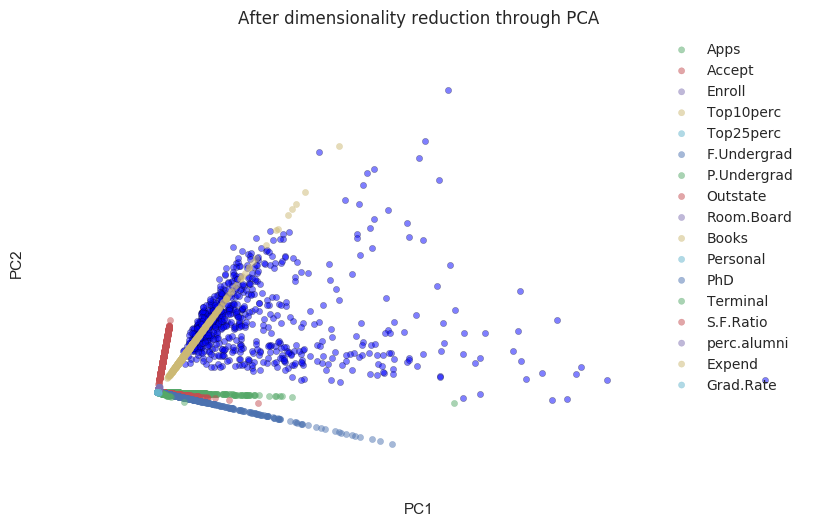

In [438]:
colors = seaborn.color_palette(n_colors = 18)
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(c_reduced_data[:, 0], c_reduced_data[:, 1], alpha = 0.5)

for i in range (1, c_data.shape[1]):
    d = pd.DataFrame(np.zeros((c_data.shape[0], c_data.shape[1])))
    d.iloc[:,i] = c_data.iloc[:,i]
    reduced_data = pca.transform(d.iloc[:, 1:])
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1],color = colors[i], alpha = 0.5, label = c_data.columns.tolist()[i])
plt.xticks(())
plt.yticks(())
plt.title('After dimensionality reduction through PCA')
# for label, x, y in zip(s_data['State'], s_reduced_data[:, 0], s_reduced_data[:, 1]):
#     plt.annotate(
#         label,
#         xy=(x, y), xytext=(-20, 20),
#         textcoords='offset points', ha='left', va='bottom',
#         bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.1),
#         arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Looking at the plot, the variable that strongly correlated with the first component is Apps.the variable that strongly correlated with the first component is Outstate.


# Question 4

## Part 1
Perform PCA on the dataset and plot the observations on the first and second principal components

In [155]:
def cluster(df, numClusters):
    km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
    km.fit(df)
    #km.labels_

    colors =['red', 'green', 'orange', 'blue']
    colors_p = [colors[l] for l in km.labels_]
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    plt.scatter(s_reduced_data[:, 0], s_reduced_data[:, 1], color = colors_p, alpha = 0.5)
    plt.xticks(())
    plt.yticks(())
    plt.title('Predicted Clusters\n k = {}'.format(numClusters))
    for label, x, y in zip(s_data['State'], s_reduced_data[:, 0], s_reduced_data[:, 1]):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-20, 20),
            textcoords='offset points', ha='left', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.1),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    plt.show()

    clusteringDict={}
    for i in range(len(km.labels_)):
        string = str(km.labels_[i])
        #print(string)
        if string in clusteringDict.keys():
            clusteringDict[string].append(s_data['State'][i])
        else:
            clusteringDict[string]= [s_data['State'][i]]
    return clusteringDict

In [143]:
s_data = pd.read_csv('USArrests.csv')
s_data[:3]

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0


In [144]:
s_reduced_data = PCA().fit_transform(s_data.iloc[:, 1:])
pd.DataFrame(s_reduced_data)[:3]

,0,1,2,3
0,64.802164,11.448007,-2.494933,2.407901
1,92.827450,17.982943,20.126575,-4.094047
2,124.068216,-8.830403,-1.687448,-4.353685


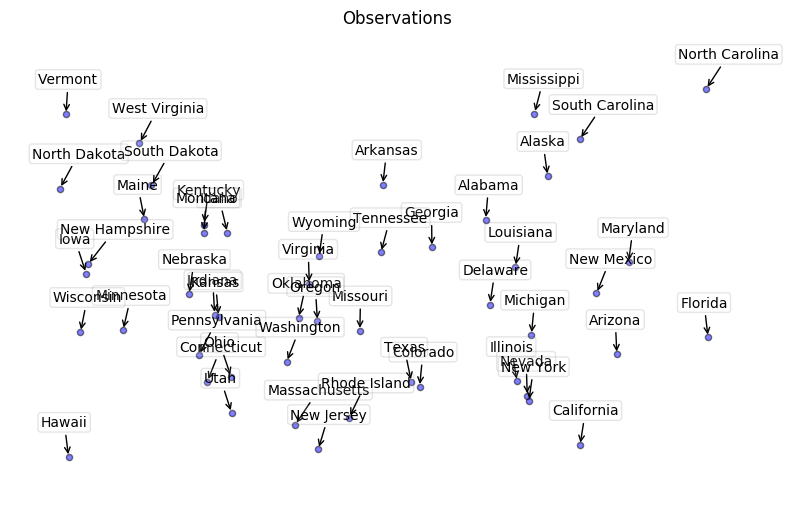

In [162]:
#colors =['red', 'green', 'orange', 'blue']
#colors_p = [colors[l] for l in km.labels_]
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(s_reduced_data[:, 0], s_reduced_data[:, 1], alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Observations')
for label, x, y in zip(s_data['State'], s_reduced_data[:, 0], s_reduced_data[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='left', va='bottom',
        bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.1),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.show()

## Part 2
Perform $K$-means clustering with $K=2$. Plot the observations on the first and second principal components and color-code each state based on their cluster membership. Describe your results.

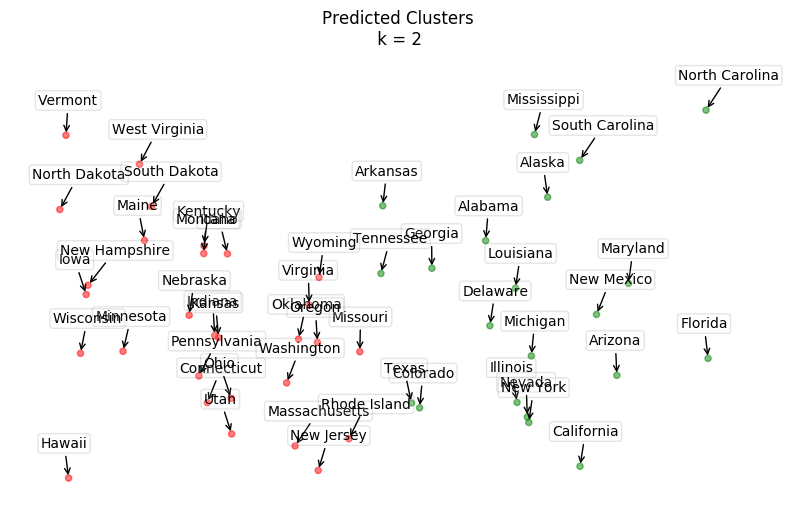

Using raw data and two clusters:
Cluster 1
 ['Connecticut', 'Hawaii', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Maine', 'Massachusetts', 'Minnesota', 'Missouri', 'Montana', 'Nebraska', 'New Hampshire', 'New Jersey', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Dakota', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

Cluster 2
 ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Delaware', 'Florida', 'Georgia', 'Illinois', 'Louisiana', 'Maryland', 'Michigan', 'Mississippi', 'Nevada', 'New Mexico', 'New York', 'North Carolina', 'South Carolina', 'Tennessee', 'Texas']


In [156]:
c_dict_p2 = cluster(s_data.iloc[:, 1:], 2)

print("Using raw data and two clusters:\nCluster 1\n",c_dict_p2['0'])
print("\nCluster 2\n",c_dict_p2['1'])

Observing from the plot, two clusters are sparated clearly.

## Part 3
Perform $K$-means clustering with $K=4$. Plot the observations on the first and second principal components and color-code each state based on their cluster membership. Describe your results.

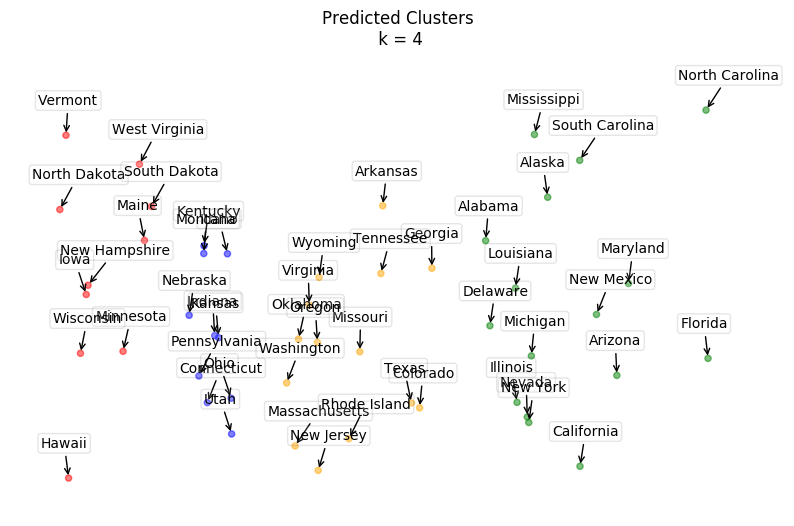

Using raw data and four clusters:
Cluster 1
 ['Hawaii', 'Iowa', 'Maine', 'Minnesota', 'New Hampshire', 'North Dakota', 'South Dakota', 'Vermont', 'West Virginia', 'Wisconsin']

Cluster 2
 ['Alabama', 'Alaska', 'Arizona', 'California', 'Delaware', 'Florida', 'Illinois', 'Louisiana', 'Maryland', 'Michigan', 'Mississippi', 'Nevada', 'New Mexico', 'New York', 'North Carolina', 'South Carolina']

Cluster 3
 ['Arkansas', 'Colorado', 'Georgia', 'Massachusetts', 'Missouri', 'New Jersey', 'Oklahoma', 'Oregon', 'Rhode Island', 'Tennessee', 'Texas', 'Virginia', 'Washington', 'Wyoming']

Cluster 4
 ['Connecticut', 'Idaho', 'Indiana', 'Kansas', 'Kentucky', 'Montana', 'Nebraska', 'Ohio', 'Pennsylvania', 'Utah']


In [157]:
c_dict_p3 = cluster(s_data.iloc[:, 1:], 4)

print("Using raw data and four clusters:\nCluster 1\n",c_dict_p3['0'])
print("\nCluster 2\n",c_dict_p3['1'])
print("\nCluster 3\n",c_dict_p3['2'])
print("\nCluster 4\n",c_dict_p3['3'])

Observing from the plot, four clusters are separated clearly.

## Part 4
Perform $K$-means clustering with $K=3$. Plot the observations on the first and second principal components and color-code each state based on their cluster membership. Describe your results.


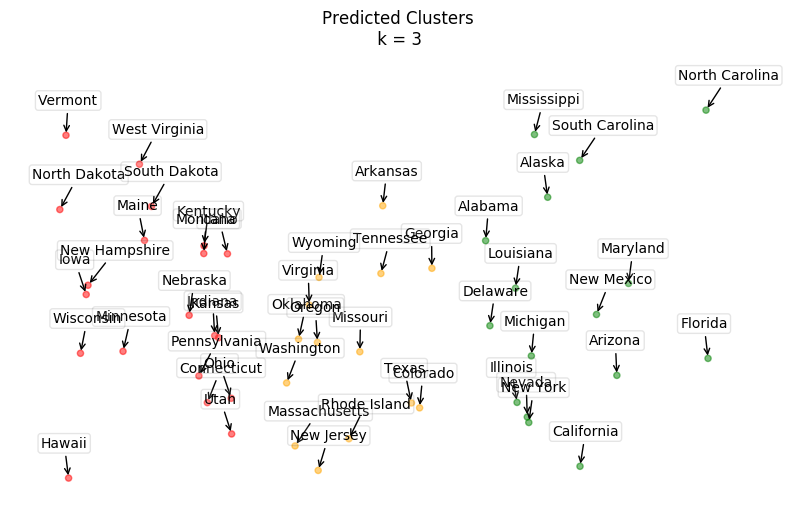

Using raw data and three clusters:
Cluster 1
 ['Connecticut', 'Hawaii', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Maine', 'Minnesota', 'Montana', 'Nebraska', 'New Hampshire', 'North Dakota', 'Ohio', 'Pennsylvania', 'South Dakota', 'Utah', 'Vermont', 'West Virginia', 'Wisconsin']

Cluster 2
 ['Alabama', 'Alaska', 'Arizona', 'California', 'Delaware', 'Florida', 'Illinois', 'Louisiana', 'Maryland', 'Michigan', 'Mississippi', 'Nevada', 'New Mexico', 'New York', 'North Carolina', 'South Carolina']

Cluster 3
 ['Arkansas', 'Colorado', 'Georgia', 'Massachusetts', 'Missouri', 'New Jersey', 'Oklahoma', 'Oregon', 'Rhode Island', 'Tennessee', 'Texas', 'Virginia', 'Washington', 'Wyoming']


In [158]:
c_dict_p4 = cluster(s_data.iloc[:, 1:], 3)
print("Using raw data and three clusters:\nCluster 1\n",c_dict_p4['0'])
print("\nCluster 2\n",c_dict_p4['1'])
print("\nCluster 3\n",c_dict_p4['2'])

## Part 5
Perform $K$-means clustering with $K=3$ on the first two principal components score vectors, rather than the raw data. Describe your results and compare them to the clustering results with $K=3$ based on the raw data.

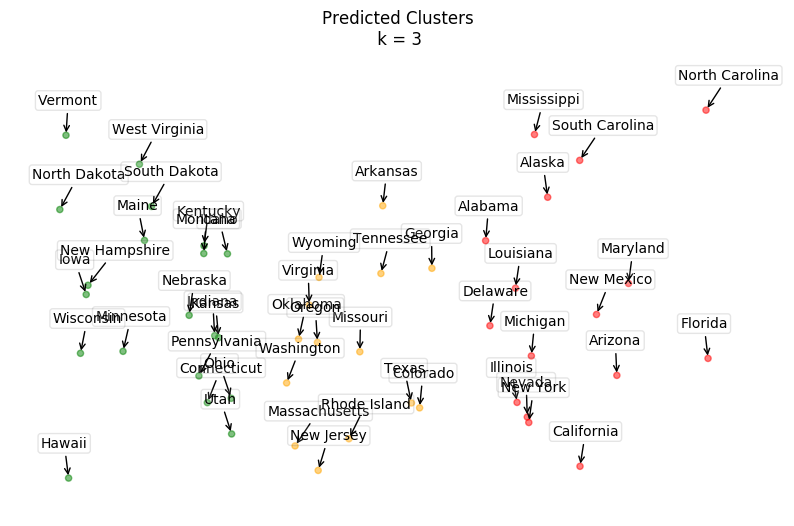

Using first two principal components and three clusters:
Cluster 1
 ['Alabama', 'Alaska', 'Arizona', 'California', 'Delaware', 'Florida', 'Illinois', 'Louisiana', 'Maryland', 'Michigan', 'Mississippi', 'Nevada', 'New Mexico', 'New York', 'North Carolina', 'South Carolina']

Cluster 2
 ['Connecticut', 'Hawaii', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Maine', 'Minnesota', 'Montana', 'Nebraska', 'New Hampshire', 'North Dakota', 'Ohio', 'Pennsylvania', 'South Dakota', 'Utah', 'Vermont', 'West Virginia', 'Wisconsin']

Cluster 3
 ['Arkansas', 'Colorado', 'Georgia', 'Massachusetts', 'Missouri', 'New Jersey', 'Oklahoma', 'Oregon', 'Rhode Island', 'Tennessee', 'Texas', 'Virginia', 'Washington', 'Wyoming']


In [159]:
c_dict_p5 = cluster(s_reduced_data[:, :2], 3)
print("Using first two principal components and three clusters:\nCluster 1\n",c_dict_p5['0'])
print("\nCluster 2\n",c_dict_p5['1'])
print("\nCluster 3\n",c_dict_p5['2'])

Comparing the two graphs and lists of clustering using raw data and using the first two principal components, we can realize that the clusterings are exactly the same. This shows us that we could safely trust PCA to reduce dimensionality when the number of features is too big in practice.j

## Part 6
Using hierarchical clustering with complete linkage and Euclidean distance, cluster the states.

In [273]:
# km = sklearn.cluster.AgglomerativeClustering(n_clusters=3,  linkage='complete')
# km.fit(s_data.iloc[:, 1:])
#s_data#.iloc[:, 1:]
#s_data_h = s_data.rename(columns={'State': 'leaves'})
s_data[:10]

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6
5,Colorado,7.9,204,78,38.7
6,Connecticut,3.3,110,77,11.1
7,Delaware,5.9,238,72,15.8
8,Florida,15.4,335,80,31.9
9,Georgia,17.4,211,60,25.8


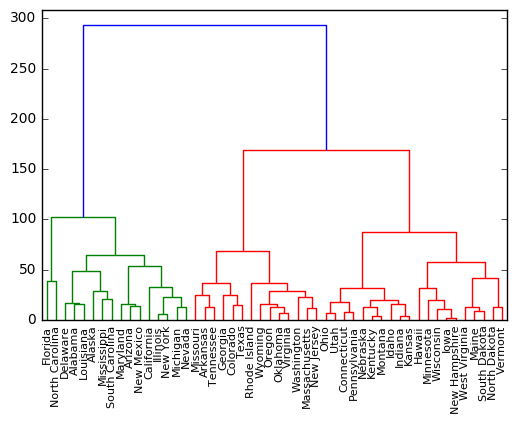

In [277]:
linkage_matrix = scipy.cluster.hierarchy.complete(s_data_h.iloc[:, 1:])
ax = scipy.cluster.hierarchy.dendrogram(linkage_matrix, labels = s_data['State'].tolist())

In [410]:
#scipy.cluster.hierarchy.dendrogram(linkage_matrix, labels = s_data['State'].tolist())['ivl']

## Part 7
Cut the dendrogram at a height that results in three distinct clusters. Which states belong to which clusters

In [323]:
l = s_data['State'].tolist()

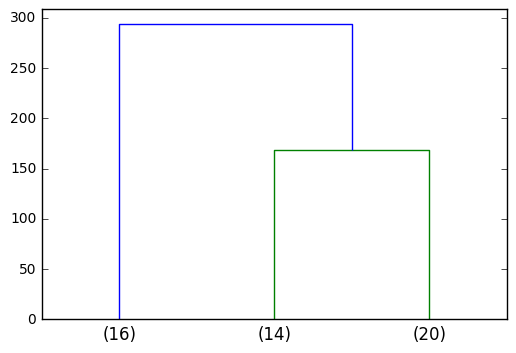

In [333]:
ax = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=3, truncate_mode='lastp', labels =[l[i] for i in [16,14,20]])

Cluster 1: ['Florida', 'North Carolina', 'Delaware', 'Alabama', 'Louisiana', 'Alaska', 'Mississippi', 'South Carolina', 'Maryland', 'Arizona', 'New Mexico', 'California', 'Illinois', 'New York', 'Michigan', 'Nevada']
Cluster 2: ['Arkansas', 'Tennessee', 'Georgia', 'Colorado', 'Texas', 'Rhode Island', 'Wyoming', 'Oregon', 'Oklahoma', 'Virginia', 'Washington', 'Massachusetts', 'New Jersey']
Cluster 3: ['Ohio', 'Utah', 'Connecticut', 'Pennsylvania', 'Nebraska', 'Kentucky', 'Montana', 'Idaho', 'Indiana', 'Kansas', 'Hawaii', 'Minnesota', 'Wisconsin', 'Iowa', 'New Hampshire', 'West Virginia', 'Maine', 'South Dakota', 'North Dakota', 'Vermont']


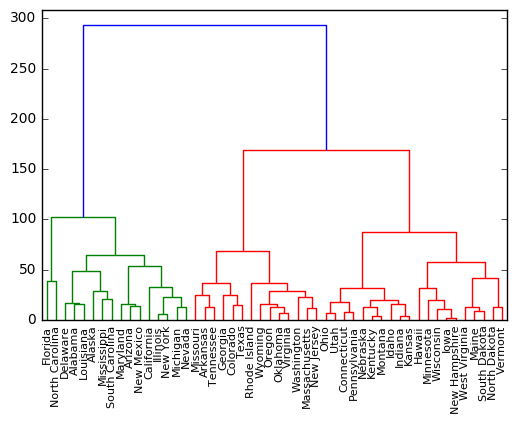

In [344]:
leaves = scipy.cluster.hierarchy.dendrogram(linkage_matrix, labels = s_data['State'].tolist())['ivl']
print('Cluster 1:',leaves[:16])
print('Cluster 2:',leaves[17:30])
print('Cluster 3:',leaves[30:])

## Part 8
Hierarchically cluster the states using complete linkage and Euclidean distance, after scaling the variables to have standard deviation $1$. What effect does scaling the variables have on the hierarchical clustering obtained? In your opinion, should the variables be scaled before the inter-observation dissimilarities are computed? Provide a justification for your answer.

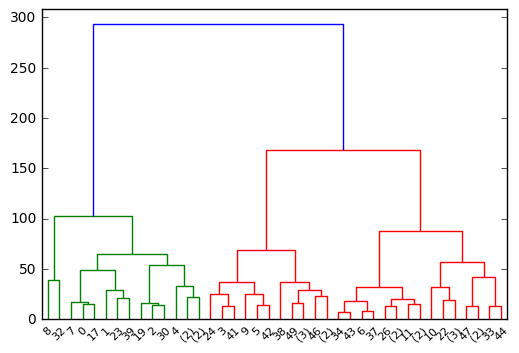

In [332]:
ax = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=5, truncate_mode='level')

In [329]:
[l[i] for i in [16,14,20]]


['Kentucky', 'Iowa', 'Massachusetts']